Using fastai to train a classifier to identify different types of objects made in metalworking.  I previously downloaded a bunch of images from google images, and they're separated by class into different folders.  I also had a folder of images (custom) of pictures taken from a metalworking company; the eventual goal is to be able to automatically classify these pictures.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
!pwd

In [ ]:
!ls ../furniture/

In [3]:
path = Path('../furniture')

# Define the data and train!

In [38]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid_pct=0.2, ds_tfms=get_transforms(), 
                                  size=256, bs=40, num_workers=4).normalize(imagenet_stats)

The order of classes here is important for when we want to do inference later:

In [28]:
data.classes

['bookshelf', 'table', 'door', 'railing', 'console']

I ran this cell for each folder to check all the images:

In [31]:
verify_images(path/'train'/'console', delete=False, max_workers=8)

In [32]:
!ls {path}/'train'/'door'/

00000000.jpg  00000122.jpg  00000252.jpg  00000385.jpg	00000511.jpg
00000001.jpg  00000123.jpg  00000253.jpg  00000386.jpg	00000512.jpg
00000002.jpg  00000124.jpg  00000254.jpg  00000387.jpg	00000513.jpg
00000003.jpg  00000125.jpg  00000255.jpg  00000388.jpg	00000514.jpg
00000004.jpg  00000126.jpg  00000258.jpg  00000389.jpg	00000516.jpg
00000005.jpg  00000127.jpg  00000259.jpg  00000390.jpg	00000517.jpg
00000006.jpg  00000128.jpg  00000261.jpg  00000391.jpg	00000518.jpg
00000007.jpg  00000129.jpg  00000262.jpg  00000392.jpg	00000519.jpg
00000008.jpg  00000131.jpg  00000263.jpg  00000393.jpg	00000520.jpg
00000009.jpg  00000135.jpg  00000264.jpg  00000394.jpg	00000521.jpg
00000010.jpg  00000136.jpg  00000266.jpg  00000396.jpg	00000522.jpg
00000011.jpg  00000137.jpg  00000267.jpg  00000397.jpg	00000523.jpg
00000012.jpg  00000138.jpg  00000271.jpg  00000398.jpg	00000524.jpg
00000013.jpg  00000139.jpg  00000272.jpg  00000399.jpg	00000525.jpg
00000014.jpg  00000140.jpg  00000273.jpg  000004

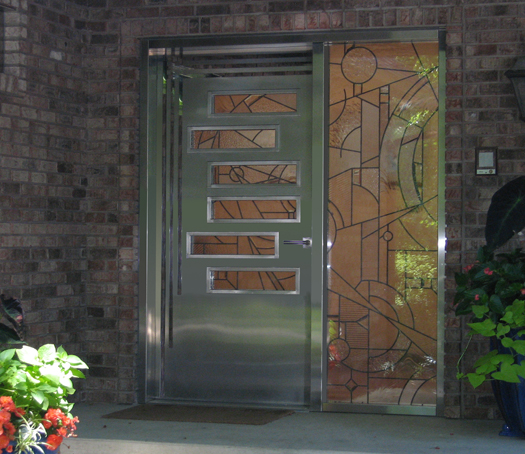

In [33]:
img = open_image(path/'train'/'door'/'00000006.jpg')
img

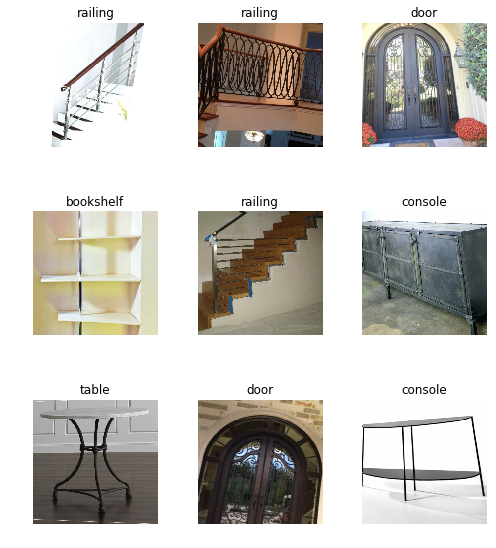

In [39]:
data.show_batch(rows=3, figsize=(7, 8))

In [35]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bookshelf', 'table', 'door', 'railing', 'console'], 5, 1730, 432)

In [40]:
learn34 = create_cnn(data, models.resnet34, metrics=error_rate)

In [42]:
learn34.fit_one_cycle(10)

Total time: 03:35
epoch  train_loss  valid_loss  error_rate
1      0.191577    0.204992    0.064815    (00:21)
2      0.201685    0.197749    0.060185    (00:24)
3      0.215767    0.208435    0.060185    (00:21)
4      0.179384    0.250395    0.064815    (00:21)
5      0.172820    0.269785    0.071759    (00:21)
6      0.154343    0.251715    0.067130    (00:21)
7      0.140083    0.279702    0.069444    (00:21)
8      0.118261    0.244257    0.055556    (00:21)
9      0.126282    0.242282    0.062500    (00:20)
10     0.111618    0.254188    0.064815    (00:21)



In [43]:
learn34.save('furniture-1-resnet34')

In [41]:
learn34.load('furniture-1-resnet34')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (1730 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (1730 items)
[PosixPath('../furniture/valid/bookshelf/Console001.jpg') PosixPath('../furniture/valid/bookshelf/P118.jpg')
 PosixPath('../furniture/valid/bookshelf/0926180706a.jpg') PosixPath('../furniture/valid/bookshelf/P132.jpg') ...
 PosixPath('../furniture/train/console/00000524.jpg') PosixPath('../furniture/train/console/00000302.jpg')
 PosixPath('../furniture/train/console/00000117.jpg') PosixPath('../furniture/train/console/00000254.jpg')]
Path: ../furniture;
Valid: LabelList
y: CategoryList (432 items)
['door' 'table' 'door' 'console' ... 'railing' 'railing' 'table' 'railing']
Path: .
x: ImageItemList (432 items)
[PosixPath('../furniture/train/door/00000398.jpg') PosixPath('../furniture/train/table/00000129.jpg')
 PosixPath('../furniture/train/door/00000367.jpg') PosixPath('../furniture/

I repeated the training multiple times using different sizes of images.  I think the smallest image size I used was 64, and even though I continued training using larger images, I don't recall improving on the results I had after the initial training run.  I'll have to look into that more in the future to check that this is actually what happened...

Next we use the learning rate finder built in to fast.ai to give us guidance about what LR to use after unfreezing

In [44]:
learn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


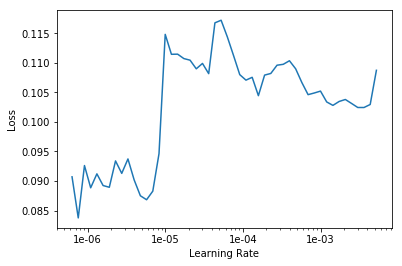

In [45]:
learn34.recorder.plot()

In [ ]:
learn34.unfreeze()

In [ ]:
learn34.fit_one_cycle(2, max_lr=slice(1e-8, 1e-6))

In [ ]:
learn34.save('furniture-2-resnet34')

In [ ]:
learn34.freeze()

# Evaluating our results

In [46]:
interp34 = ClassificationInterpretation.from_learner(learn34)

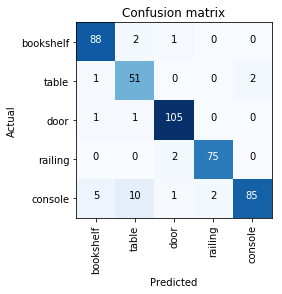

In [47]:
interp34.plot_confusion_matrix()

In [ ]:
from fastai.widgets import *

losses, idxs = interp34.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn34, ds_type=DatasetType.Train)

In [ ]:
ImageRelabeler(ds, idxs)

One of the difficulties with this dataset is that even as a human, I am often unsure about the distinction between a console and a table.

# Adding the "real" pictures

Now I'm going to use the pictures I actually want to classify automatically as my validation set.

In [26]:
data2 = ImageDataBunch.from_folder(path, train="train", valid="valid", ds_tfms=get_transforms(), 
                                  size=224, num_workers=4, bs=40).normalize(imagenet_stats)


In [59]:
learn34c = create_cnn(data2, models.resnet34, metrics=error_rate)

In [62]:
learn34c.load('furniture-2-resnet34')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (2103 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (2103 items)
[PosixPath('../furniture/train/bookshelf/00000502.jpg') PosixPath('../furniture/train/bookshelf/00000325.jpg')
 PosixPath('../furniture/train/bookshelf/00000521.jpg') PosixPath('../furniture/train/bookshelf/00000000.jpg') ...
 PosixPath('../furniture/train/console/00000302.jpg') PosixPath('../furniture/train/console/00000117.jpg')
 PosixPath('../furniture/train/console/00000180.jpg') PosixPath('../furniture/train/console/00000254.jpg')]
Path: ../furniture;
Valid: LabelList
y: CategoryList (59 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (59 items)
[PosixPath('../furniture/valid/bookshelf/Console001.jpg') PosixPath('../furniture/valid/bookshelf/P118.jpg')
 PosixPath('../furniture/valid/bookshelf/09261807

In [61]:
learn34c.fit_one_cycle(6)

Total time: 02:08
epoch  train_loss  valid_loss  error_rate
1      0.213894    0.151582    0.050847    (00:24)
2      0.208544    0.232327    0.067797    (00:20)
3      0.183850    0.309941    0.067797    (00:20)
4      0.172533    0.337690    0.118644    (00:20)
5      0.155925    0.297844    0.118644    (00:22)
6      0.136945    0.265959    0.118644    (00:20)



In [57]:
learn34c.save('furniture-2c-resnet34')

In [63]:
interp34c = ClassificationInterpretation.from_learner(learn34c)

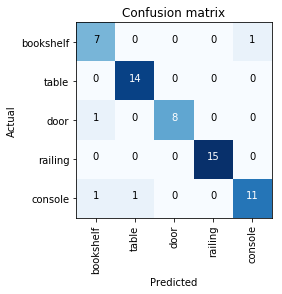

In [64]:
interp34c.plot_confusion_matrix()

In [65]:
interp34c.most_confused()

[]

# Now with ResNet 50

In [13]:
data = ImageDataBunch.from_folder(path, train="train", valid_pct=0.2, ds_tfms=get_transforms(), 
                                  size=256, bs=40, num_workers=4).normalize(imagenet_stats)

In [14]:
learn50 = create_cnn(data, models.resnet50, metrics=error_rate)

In [15]:
learn50.load('furniture-1-resnet50')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (1730 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (1730 items)
[PosixPath('../furniture/valid/bookshelf/Console001.jpg') PosixPath('../furniture/valid/bookshelf/P118.jpg')
 PosixPath('../furniture/valid/bookshelf/0926180706a.jpg') PosixPath('../furniture/valid/bookshelf/P132.jpg') ...
 PosixPath('../furniture/train/console/00000524.jpg') PosixPath('../furniture/train/console/00000302.jpg')
 PosixPath('../furniture/train/console/00000180.jpg') PosixPath('../furniture/train/console/00000254.jpg')]
Path: ../furniture;
Valid: LabelList
y: CategoryList (432 items)
['door' 'table' 'railing' 'bookshelf' ... 'door' 'table' 'door' 'console']
Path: .
x: ImageItemList (432 items)
[PosixPath('../furniture/train/door/00000140.jpg') PosixPath('../furniture/train/table/00000071.jpg')
 PosixPath('../furniture/train/railing/00000412.jpg') PosixPath('../furnitur

In [17]:
learn50.fit_one_cycle(3)

Total time: 01:21
epoch  train_loss  valid_loss  error_rate
1      0.278151    0.219833    0.071759    (00:27)
2      0.259967    0.230419    0.085648    (00:27)
3      0.242566    0.233796    0.087963    (00:26)



In [7]:
learn50.save('furniture-1-resnet50')

In [18]:
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


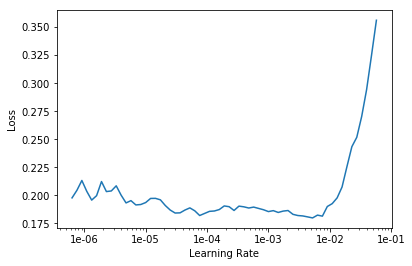

In [19]:
learn50.recorder.plot()

In [23]:
learn50.load('furniture-1-resnet50')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (1730 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (1730 items)
[PosixPath('../furniture/valid/bookshelf/Console001.jpg') PosixPath('../furniture/valid/bookshelf/P118.jpg')
 PosixPath('../furniture/valid/bookshelf/0926180706a.jpg') PosixPath('../furniture/valid/bookshelf/P132.jpg') ...
 PosixPath('../furniture/train/console/00000524.jpg') PosixPath('../furniture/train/console/00000302.jpg')
 PosixPath('../furniture/train/console/00000180.jpg') PosixPath('../furniture/train/console/00000254.jpg')]
Path: ../furniture;
Valid: LabelList
y: CategoryList (432 items)
['door' 'table' 'railing' 'bookshelf' ... 'door' 'table' 'door' 'console']
Path: .
x: ImageItemList (432 items)
[PosixPath('../furniture/train/door/00000140.jpg') PosixPath('../furniture/train/table/00000071.jpg')
 PosixPath('../furniture/train/railing/00000412.jpg') PosixPath('../furnitur

In [21]:
learn50.unfreeze()

In [22]:
learn50.fit_one_cycle(5, max_lr=slice(1e-4, 1e-3))

Total time: 02:54
epoch  train_loss  valid_loss  error_rate
1      0.498468    0.345053    0.115741    (00:35)
2      0.486155    0.482839    0.164352    (00:34)
3      0.449278    0.325175    0.127315    (00:33)
4      0.327858    0.232202    0.074074    (00:34)
5      0.216570    0.245537    0.083333    (00:35)



In [15]:
learn50.save('furniture-2-resnet50')

In [24]:
learn50.freeze()

In [27]:
learn50c = create_cnn(data2, models.resnet50, metrics=error_rate)

In [28]:
data2.classes, data2.c, len(data2.train_ds), len(data2.valid_ds)

(['bookshelf', 'table', 'door', 'railing', 'console'], 5, 2103, 59)

In [29]:
learn50c.load('furniture-1-resnet50')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (2103 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (2103 items)
[PosixPath('../furniture/train/bookshelf/00000502.jpg') PosixPath('../furniture/train/bookshelf/00000325.jpg')
 PosixPath('../furniture/train/bookshelf/00000521.jpg') PosixPath('../furniture/train/bookshelf/00000000.jpg') ...
 PosixPath('../furniture/train/console/00000302.jpg') PosixPath('../furniture/train/console/00000117.jpg')
 PosixPath('../furniture/train/console/00000180.jpg') PosixPath('../furniture/train/console/00000254.jpg')]
Path: ../furniture;
Valid: LabelList
y: CategoryList (59 items)
['bookshelf' 'bookshelf' 'bookshelf' 'bookshelf' ... 'console' 'console' 'console' 'console']
Path: .
x: ImageItemList (59 items)
[PosixPath('../furniture/valid/bookshelf/Console001.jpg') PosixPath('../furniture/valid/bookshelf/P118.jpg')
 PosixPath('../furniture/valid/bookshelf/09261807

In [30]:
learn50c.fit_one_cycle(5)

Total time: 02:06
epoch  train_loss  valid_loss  error_rate
1      0.356084    0.595726    0.220339    (00:28)
2      0.302410    0.760787    0.305085    (00:24)
3      0.245712    0.769357    0.305085    (00:23)
4      0.205071    0.771529    0.288136    (00:25)
5      0.167304    0.788279    0.288136    (00:23)



In [ ]:
learn50c.save('furniture-2-resnet50')

In [31]:
interp50c = ClassificationInterpretation.from_learner(learn50c)

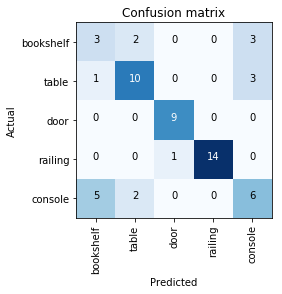

In [32]:
interp50c.plot_confusion_matrix()